In [2]:
import numpy as np 
import pandas as pd 
import cvxpy as cp 

In [16]:
# Eg: Least squares / Linear Regression
"""
Assuming we have dataset of m users containing n features. A - Rmxn, B - Rm, x, Rn
Each row of A is the features for user i (1-->m) , while the corresponding entry in B is the measurement we want to predict from A
"""
# step 1: Generate the data for the parameters
m = 20 # define m (fx. users) and n (fx. features)
n = 15
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# define the optimisation problem
x = cp.Variable(n)
cost = cp.sum_squares(A @ x - b) #the objective function
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

# print results of the OP problem
print('The optimal value is (residual) ', prob.value)
print('The optimate value of x ')
print(x.value)
print("The norm of the residual is ", cp.norm( A @ x - b, p = 2).value) # the parameter p=2 specifies the Euclidean norm (also called the L2 norm)

The optimal value is (residual)  7.005909828287486
The optimate value of x 
[ 0.17492418 -0.38102551  0.34732251  0.0173098  -0.0845784  -0.08134019
  0.293119    0.27019762  0.17493179 -0.23953449  0.64097935 -0.41633637
  0.12799688  0.1063942  -0.32158411]
The norm of the residual is  2.6468679280023557


In [ ]:
# define a linear optimisation problem and solve
m = 15
n = 10
np.random.seed(1)

s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 + s0
c = -A.T @ lamb0

x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T @ x), [A @ x <= b])
prob.solve()

print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)


The optimal value is -15.220912604404896
A solution x is
[-1.1015836  -0.16207265 -0.90072437  0.03042621  0.61108485 -1.13141956
  1.1270734   0.87833368  0.48871908  0.89807117]
A dual solution is
[2.45894690e-09 6.11756417e-01 5.28171745e-01 1.07296862e+00
 6.38553247e-09 2.30153871e+00 1.12756421e-09 7.61206895e-01
 1.31943179e-08 2.49370376e-01 2.02551866e-09 2.06014070e+00
 3.22417209e-01 3.84054335e-01 2.94504832e-09]


In [15]:
# define a quadratic optimisation problem
m = 15
n = 10
p = 5
np.random.seed(1)

A = np.random.randn(p, n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
b = np.random.randn(p)
q = np.random.randn(n)
P = np.random.randn(n,n)
P = P.T @ P

#formulate the problem
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x),
                  [G @ x <= h,
                   A @ x == b])
prob.solve()

#print results
print('\n The optimal solution is ', prob.value)
print('A solution of X is ')
print(x.value)
print('A dual solution corresponding to inequality constraints is')
print(prob.constraints[0].dual_value)


 The optimal solution is  140.75610416038796
A solution of X is 
[-0.75169567  0.29045975 -0.29600599 -0.62557383 -3.30015321 -3.05529113
 -1.8988242  -0.50157543 -3.43283882 -0.38194722]
A dual solution corresponding to inequality constraints is
[ 0.          0.          0.          0.         73.74440746 52.3391249
  0.          0.          0.          0.          0.         42.61704077
  7.68787427  0.          0.        ]


Convex optimization can be used to solve many problems that arise in control.
In this example we show how to solve such a problem using CVXPY.
We have a system with a state $x_t\in {\bf R}^n$ that varies over the time steps $t=0,\ldots,T$, and inputs or actions $u_t\in {\bf R}^m$ we can use at each time step to affect the state.
For example, $x_t$ might be the position and velocity of a rocket and $u_t$ the output of the rocket's thrusters.
We model the evolution of the state as a linear dynamical system, i.e.,

$$ x_{t+1} = Ax_t + Bu_t $$

where $A \in {\bf R}^{n\times n}$ and $B \in {\bf R}^{n\times m}$ are known matrices.

Our goal is to find the optimal actions $u_0,\ldots,u_{T-1}$ by solving the optimization problems


$$
\begin{aligned} 
\text{minimize} \quad & \sum_{t=0}^{T-1} \ell (x_t,u_t) + \ell_T(x_T) \\
\text{subject to} \quad & x_{t+1} = Ax_t + Bu_t, \quad t=0, \ldots, T-1 \\
& (x_t,u_t) \in \mathcal{C}, \quad x_T \in \mathcal{C}_T
\end{aligned}
$$


where $\ell: {\bf R}^n \times {\bf R}^m\to {\bf R}$ is the stage cost, $\ell_T$ is the terminal cost,
$\mathcal C$ is the state/action constraints, and $\mathcal C_T$ is the terminal constraint.
The optimization problem is convex if the costs and constraints are convex.


## Example

In the following code we solve a control problem with $n=8$ states, $m=2$ inputs, and horizon $T=50$.
The matrices $A$ and $B$ and the initial state $x_0$ are randomly chosen (with $A\approx I$).
We use the (traditional) stage cost $\ell(x,u) = \|x\|_2^2 + \|u\|_2^2$, the input constraint $\|u_t\|_\infty \leq 1$, and the terminal constraint $x_{T}=0$.

In [22]:
# modelling a simple MPC controller 
n = 8; m =2; T = 50 # n states, m inputs
np.random.seed(1)

alpha = 0.2; beta = 3

A = np.eye(n) - alpha * np.random.rand(n,n) #scale it using alpha and it is a diagonal matrix A.x(t)
B = np.random.randn(n, m)   # state space model B sizee of imput m B.u(t)

x0 = beta * np.random.randn(n) # define the initial states of the system

# fomulate the optimisation problem
# since this is a MPC model, the states evolve over time till horizon T = 50, so no. of variable x = 8 * 50
x = cp.Variable((n, T+1)) # We need one final states after the Tth horizon
u = cp.Variable((m, T)) # we need m inputs for each time step 

# objective function is a summation of all time steps
cost = 0
constr = []
for t in range(T):
    cost += cp.sum_squares(x[:, t+1]) + cp.sum_squares(u[:, t]) # objective fn
    constr += [x[:, t+1]  == A @ x[:, t] + B @ u[:,t], cp.norm(u[:, t], "inf") <= 1] # concatenates constraints for each time step

constr += [x[:, T] == 0, x[:, 0] == x0] # add the constraints to follow initial condition and final x at T should be 0

problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

2515.656065442021

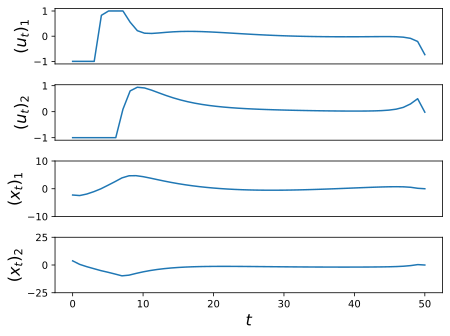

In [23]:
# Plot results.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0, :].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4, 1, 2)
plt.plot(u[1, :].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (x_t)_1.
plt.subplot(4, 1, 3)
x1 = x[0, :].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4, 1, 4)
x2 = x[1, :].value
plt.plot(range(51), x2)
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
import numpy as np

C = np.array([[1, -1, 0, 0, 0, 1], 
              [0, 0, 0, -1, 0, 1], 
              [1, 0, 1, 0, -1, 0], 
              [0, 0, -1, 1, 0, 0], 
              [2, 3, 0, 0, 6, 0], 
              [-2, 0, 4, 5, 0, 8]])

d = np.array([[0], [-16], [0], [16], [30], [0]])

# Correct function to solve the system of linear equations
solution = np.linalg.solve(C, d)

print(solution)

[[ 6.]
 [ 2.]
 [-4.]
 [12.]
 [ 2.]
 [-4.]]


In [5]:
6 ** 2 * 2

72